In [106]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 8)
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

def display_df(df, rows=pd.options.display.max_rows,
               cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)

# Apply, String Methods

This section introduces *apply*, an operation to transform columns of data.
We'll also cover built-in string methods `pandas` that provide shorthands for
some uses of apply.

In [107]:
baby = pd.read_csv('babynames.csv')
baby

,Name,Sex,Count,Year
0,Liam,M,19659,2020
1,Noah,M,18252,2020
2,Oliver,M,14147,2020
...,...,...,...,...
2020719,Verona,F,5,1880
2020720,Vertie,F,5,1880
2020721,Wilma,F,5,1880


In the baby names New York Times article ({cite}`williamsLilith2021`), Pamela
mentions that names starting with the letter "L" and "K" became popular
after 2000. On the other hand, names starting with the letter "J" peaked in
popularity in the 1970s and 1980s and have dropped off in popularity since. We
can verify these claims using the `baby` dataset.

You can approach this problem using the following steps:

1. Calculate the first letter of each name.
2. Group by the first letter and year.
3. Aggregate the name counts by summing.

To complete the first step, you can *apply* a function to the `Name` column. 

## Apply 

`pd.Series` objects contain an `.apply()` method that takes in a function and
applies it to each value in the series. For instance, to find the lengths of
each name, you can apply the `len` function.

In [109]:
names = baby['Name']
names.apply(len)

0          4
1          4
2          6
          ..
2020719    6
2020720    6
2020721    5
Name: Name, Length: 2020722, dtype: int64

To extract the first letter of each name, define a custom function and pass it
into `.apply()`.

In [112]:
# The argument to the function is an individual value in the series. 
def first_letter(string):
    return string[0]

names.apply(first_letter)

0          L
1          N
2          O
          ..
2020719    V
2020720    V
2020721    W
Name: Name, Length: 2020722, dtype: object

Using `.apply()` is similar to using a `for` loop. The code above is roughly
equivalent to writing:

```python
result = []
for name in names:
    result.append(first_letter(name))
```

Now, we can assign the first letters to a new column in the dataframe:

In [118]:
letters = baby.assign(Firsts=names.apply(first_letter))
letters

,Name,Sex,Count,Year,Firsts
0,Liam,M,19659,2020,L
1,Noah,M,18252,2020,N
2,Oliver,M,14147,2020,O
...,...,...,...,...,...
2020719,Verona,F,5,1880,V
2020720,Vertie,F,5,1880,V
2020721,Wilma,F,5,1880,W


:::{note}
To create a new column in a dataframe, you might also encounter this syntax:

```python
baby['Firsts'] = names.apply(first_letter)
```

This mutates the `baby` table. In the code above, we use `.assign()` which
doesn't mutate the `baby` table itself; it creates a new dataframe instead. 
Mutating dataframes isn't wrong but can be a common source of bugs, especially
while you're still becoming familiar with working with notebooks. Because of
this, we'll mostly use `.assign()` in this book. 
:::

Now, we can use the `letters` dataframe to see the popularity of first letters
over time.

In [121]:
letter_counts = (letters
 .groupby(['Firsts', 'Year'])
 ['Count']
 .sum()
 .reset_index()
)
letter_counts

,Firsts,Year,Count
0,A,1880,16740
1,A,1881,16257
2,A,1882,18790
...,...,...,...
3638,Z,2018,55996
3639,Z,2019,55293
3640,Z,2020,54011


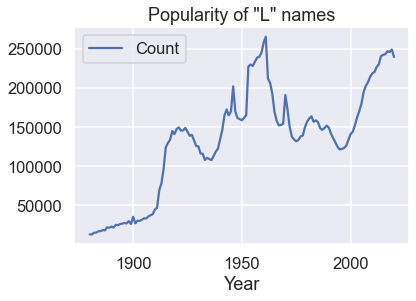

In [125]:
(letter_counts
 .loc[letter_counts['Firsts'] == 'L']
 .plot('Year', 'Count')
)
plt.title('Popularity of "L" names');

The plot shows that "L" names were popular in the 1960s, dipped in the decades
after, but have indeed resurged in popularity after 2000. 

What about "J" names?

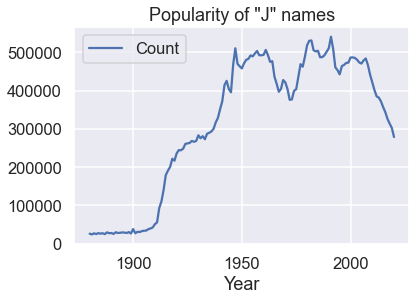

In [126]:
(letter_counts
 .loc[letter_counts['Firsts'] == 'J']
 .plot('Year', 'Count')
)
plt.title('Popularity of "J" names');

The NYT article says that "J" names were popular in the 1970s and 80s. The plot
agrees, and also shows that they have become less popular after 2000.

## The Price of Apply

The power of `.apply()` is its flexibility---you can call it with any function
that takes in a single data value and outputs a single data value.

Its flexibility has a price, though. Using `.apply()` can be slow, since
`pandas` can't optimize arbitrary functions. For example, using `.apply()` for
numeric calculations is much slower than using vectorized operations directly
on `pd.Series` objects:

In [140]:
%%timeit

# Calculate the decade using vectorized operators
baby['Year'] // 10 * 10

15 ms ± 254 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [141]:
%%timeit

def decade(yr):
    return yr // 10 * 10

# Calculate the decade using apply
baby['Year'].apply(decade)

518 ms ± 10.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The version using `.apply()` is more than 30 times slower! For numeric
operations in particular, you should prefer to work with `pd.Series` objects
directly.

## String Methods

`pandas` provides some shorthands for string manipulation in particular. To use
these shorthands, call methods on the `.str` property on `pd.Series` objects.
For example, to get the lengths of all the names, you can write:

In [146]:
baby['Name'].str.len()

0          4
1          4
2          6
          ..
2020719    6
2020720    6
2020721    5
Name: Name, Length: 2020722, dtype: int64

You can also take slices of strings in a similar way:

In [148]:
# Shorthand to get the first character of each string
# Same output as baby['Name'].apply(first_letter)
baby['Name'].str[0]

0          L
1          N
2          O
          ..
2020719    V
2020720    V
2020721    W
Name: Name, Length: 2020722, dtype: object

`pandas` also provides functionality to split, replace, and search strings.
We'll cover this in much more depth in the {ref}`ch:text` chapter. For the full
list of string methods, refer to the documentation ([link][text]).

[text]: https://pandas.pydata.org/pandas-docs/stable/user_guide/text.html

## Exercises

- Have names become longer on average over time? Produce a plot to answer this
  question. 

- Earlier in this chapter we found that you could make reasonable guesses at a
  person's age just by knowing their name. For instance, the name "Luna" has
  sharply risen in popularity after 2000, so you could guess that a person
  named "Luna" was born around after 2000. Can you make reasonable guesses at a
  person's age just from the *first letter* of their name? Write code to see
  whether this is possible, and which letters provide the most information
  about a person's age. 

- Write code to compare the speed of using `.apply()` and the `.str` accessor
  to extract the first two letters of each name in `baby`. Use the `%%timeit`
  cell magic as we've shown in this section. You'll notice that using `.apply`
  actually runs faster! See if you can use web search to find out why.

  (In general, you should think of the `.str` accessor as a convenience. If you
  are truly concerned about the performance of your code, you should time your
  code yourself.)